# Preface
This notebook uses several packages from CRAN, as well as [Bioconductor](https://bioconductor.org). For a full list of attached packages see the session info in the Appendix at the end of this notebook. Several options have been adjusted to improve appearance of plots.

In [3]:
## Load necessary packages
suppressMessages({
    
    library("xcms")
    library("CAMERA")
    library("RColorBrewer")
    library("SummarizedExperiment")
    library("tidyverse")
    library("gplots")
    library("ggrepel")
    library("Rtsne")
    library("caret")
    library("MASS")
    
})

## Set session-specific options
options(repr.plot.width = 12, # Adjust plot width for publication purposes
        repr.plot.height = 8, # Adjust plot height for publication purposes,
        scipen = -1) # Adjust scientific notation of numbers to improve readability of plots

## List mzXML files
mzXMLs <- list.files(path = getwd(), recursive = TRUE, 
                     full.names = TRUE, pattern = ".mzXML")

# Quality Control of Raw Data
The following injection order during analysis correspond to the order files are read using list.files. In case several batches were analysed, as vector containing an integer for each batch assignment of each sample must be given.

In [4]:
## List mzXML files
mzXMLs <- list.files(path = "ZicHILIC_neg", recursive = TRUE, 
                     full.names = TRUE, pattern = ".mzXML")

## Aggregate meta data
sample.name <- sub(basename(mzXMLs), pattern = ".mzXML", 
                   replacement = "", fixed = TRUE)
sample.group <- c(rep("Control", 5), rep("PCYP", 5), 
                  rep("QC", 7))
sample.order <- c(12,8,9,10,14,6,7,13,16,15,1,2,3,4,5,11,17)
sample.batch <- NA
meta <- data.frame(sample_name = sample.name, 
                   sample_group = sample.group, 
                   sample_order = sample.order, 
                   sample_batch = sample.batch, 
                   stringsAsFactors = FALSE)

## Read raw data from disk
raw <- readMSData(files = mzXMLs[order(sample.order)], 
                  pdata = new("AnnotatedDataFrame", 
                              meta[order(sample.order),]), 
                  mode = "onDisk")
## Remove column equilibration and washing phases
raw <- filterRt(raw, c(60,600))

class(raw)

print(raw)

[1] "OnDiskMSnExp"
attr(,"package")
[1] "MSnbase"

MSn experiment data ("OnDiskMSnExp")
Object size in memory: 4.99 Mb
- - - Spectra data - - -
 MS level(s): 1 
 Number of spectra: 17697 
 MSn retention times: 1:0 - 9:60 minutes
- - - Processing information - - -
Data loaded [Thu Oct 21 11:51:40 2021] 
Filter: select retention time [60-600] and MS level(s), 1 [Thu Oct 21 11:51:41 2021] 
 MSnbase version: 2.14.2 
- - - Meta data  - - -
phenoData
  rowNames: 11 12 ... 17 (17 total)
  varLabels: sample_name sample_group sample_order sample_batch
  varMetadata: labelDescription
Loaded from:
  [1] pQC_1.mzXML...  [17] pQC_7.mzXML
  Use 'fileNames(.)' to see all files.
protocolData: none
featureData
  featureNames: F01.S0116 F01.S0117 ... F17.S1156 (17697 total)
  fvarLabels: fileIdx spIdx ... spectrum (35 total)
  fvarMetadata: labelDescription
experimentData: use 'experimentData(object)'


# Inspection of Parent Compound and Internal Standard
This experiment used deuterated tryptophan as an internal standard to normalise variability introduced by injection of the samples into the mass spectrometer. Quality control in at this stage includes ensuring that both the internal standard, as well as the parent compound, have been detected properly and the within group variability is acceptable.

In [5]:
## Define colours for experimental groups
group.colours <- paste0(brewer.pal(3, "Set1")[1:3])
names(group.colours) <- c("Control", "PCYP", "QC")

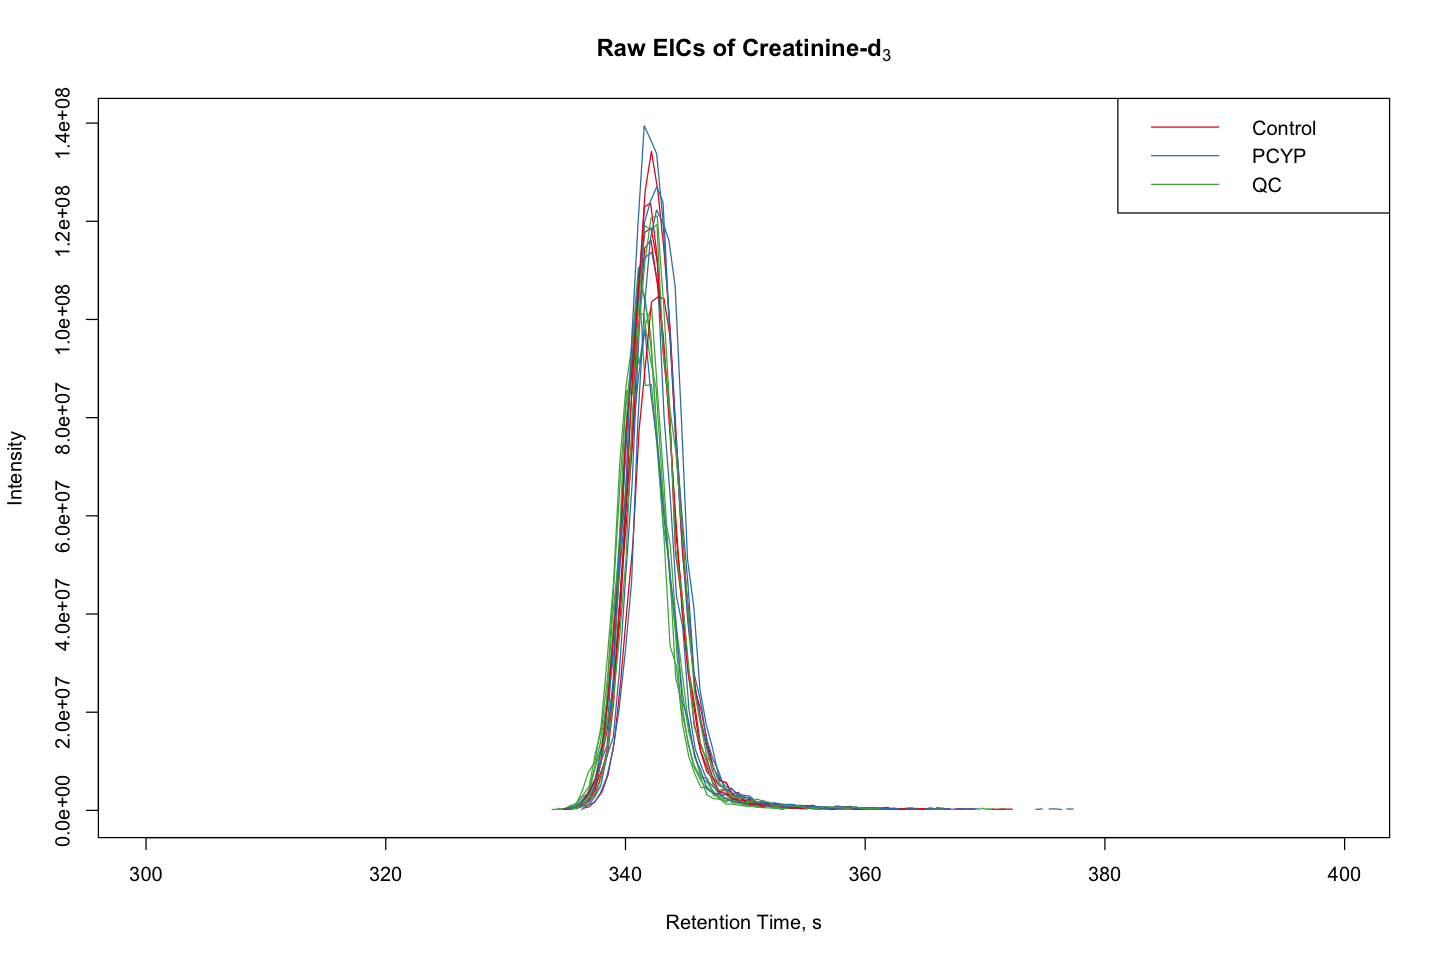

In [17]:
## Plot raw EICs of creatinine-d3 (m/z 117.0856, 25 s)
cread3.raw <- chromatogram(raw, mz = c(117.0841, 117.0871), rt = c(300, 400))

plot(cread3.raw, col = group.colours[cread3.raw$sample_group], 
     main = bquote(bold("Raw EICs of Creatinine-d"[3])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

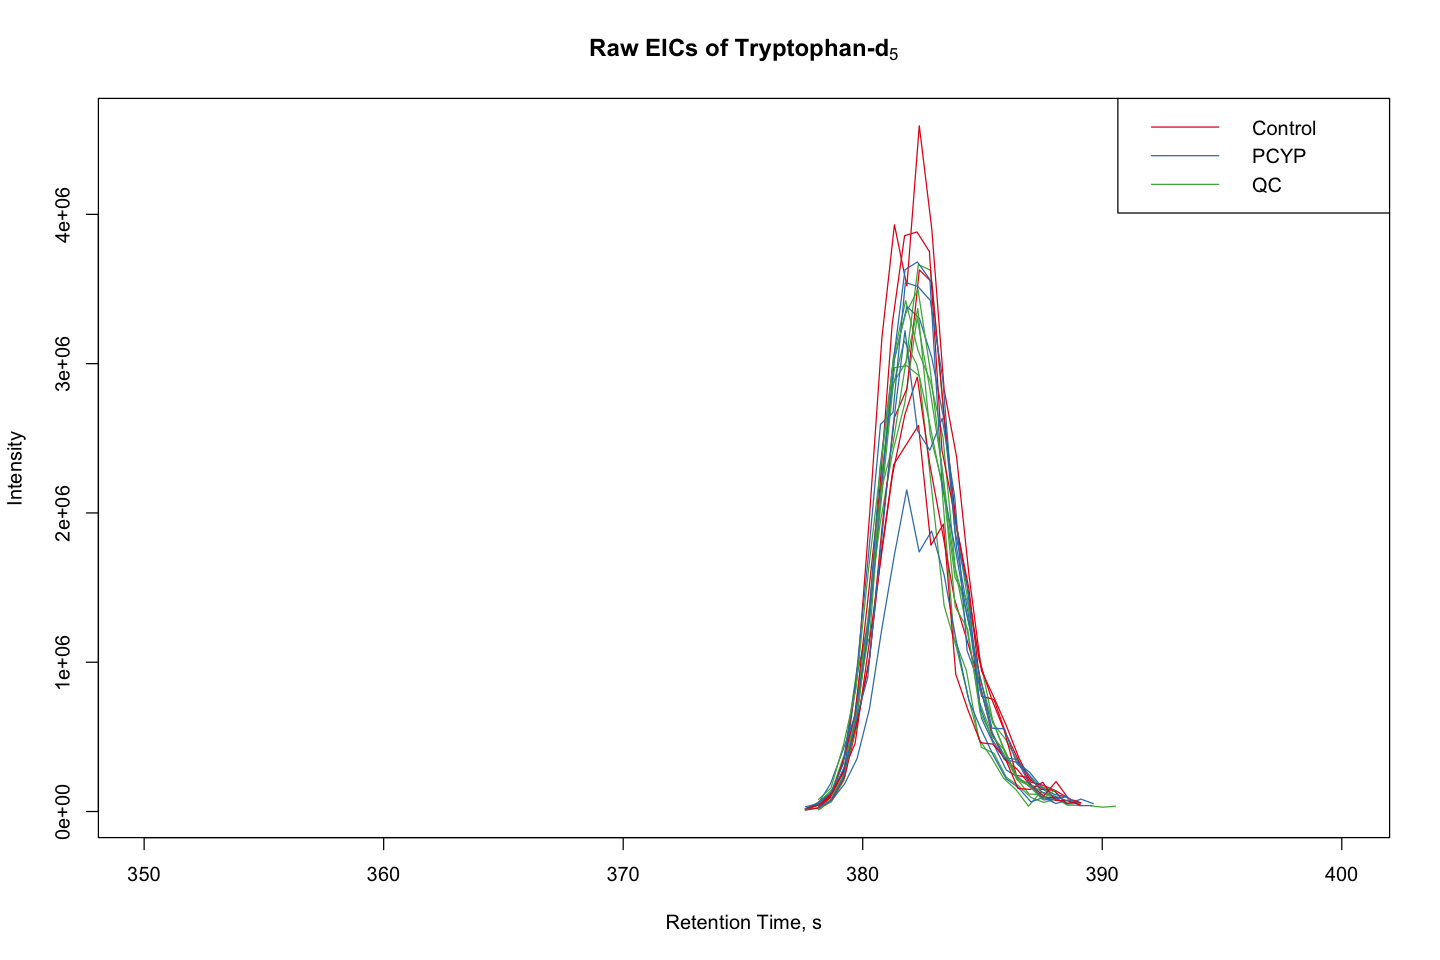

In [9]:
## Define colours for experimental groups
group.colours <- paste0(brewer.pal(3, "Set1")[1:3])
names(group.colours) <- c("Control", "PCYP", "QC")


## Plot tryptophan-d5 before processing (m/z 208.1134, 168 s)
trpd5.raw <- chromatogram(raw, mz = c(208.1124, 208.1144), rt = c(350, 400))

plot(trpd5.raw, col = group.colours[trpd5.raw$sample_group], 
     main = bquote(bold("Raw EICs of Tryptophan-d"[5])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

# Inspect Total Ion Currents of Sample Files

Total ion currents (TICs) need to be inspected in order to ensure that chromatography and mass spectrometry have been performing properly. Quality control includes the inspection of retention time drifts within TICS and evaluation of the baselines.

In [10]:
## Get total ion chromatograms
tics <- chromatogram(raw, aggregationFun = "sum")

Fehler in x$.self$finalize() : Versuch eine Nicht-Funktion anzuwenden

Fehler in x$.self$finalize() : Versuch eine Nicht-Funktion anzuwenden



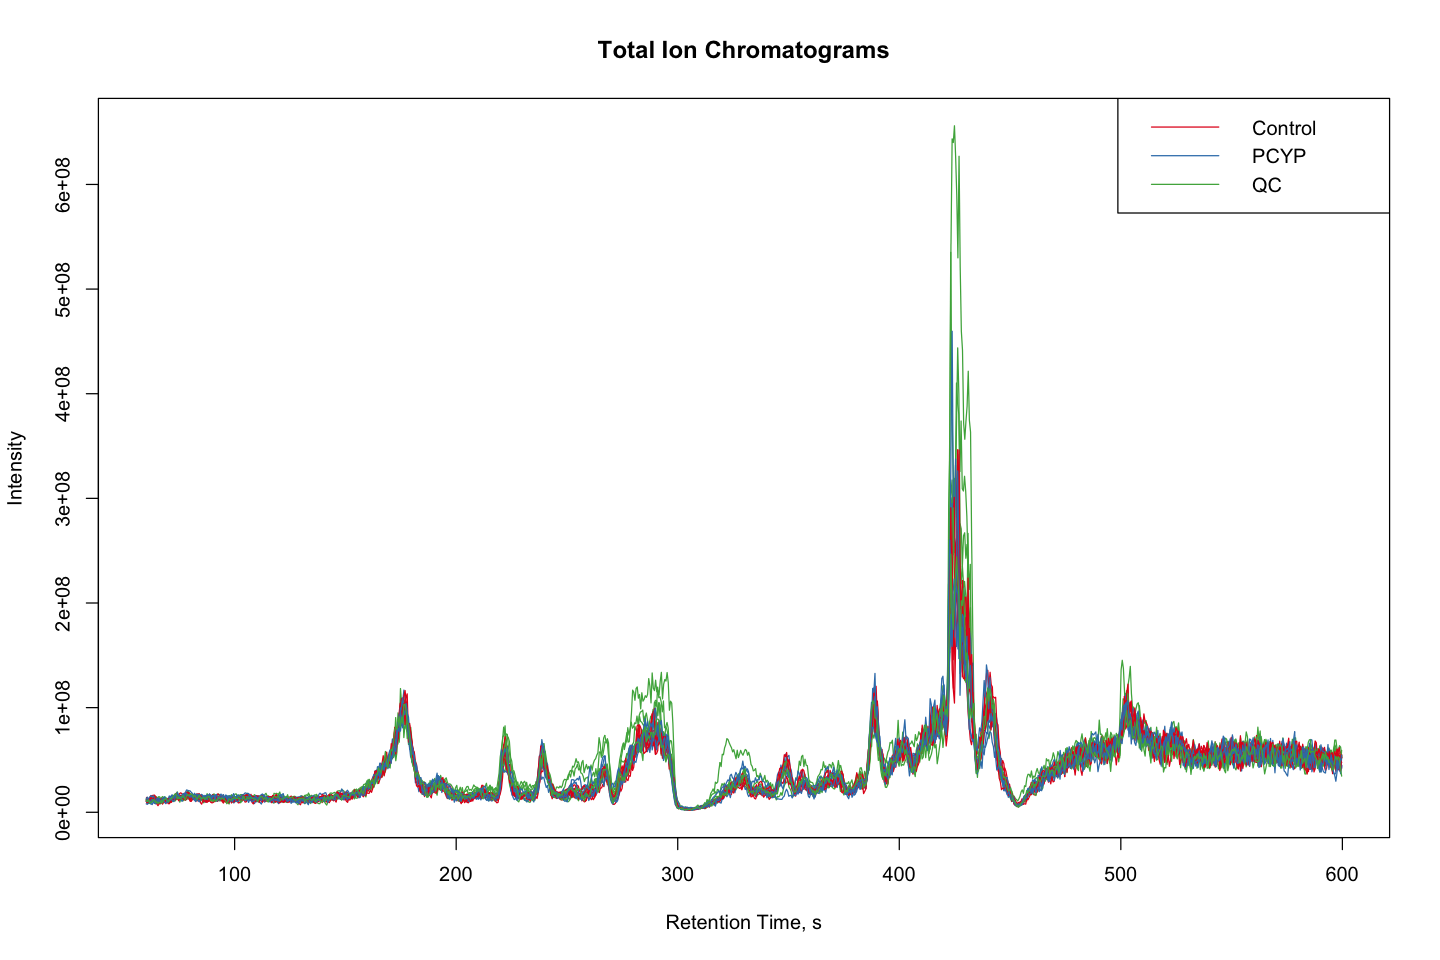

In [11]:
## Plot every total ion chromatogram of the data set
plot(tics, col = group.colours[raw$sample_group], 
     main = "Total Ion Chromatograms", ylab = "Intensity", 
     xlab = "Retention Time, s")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

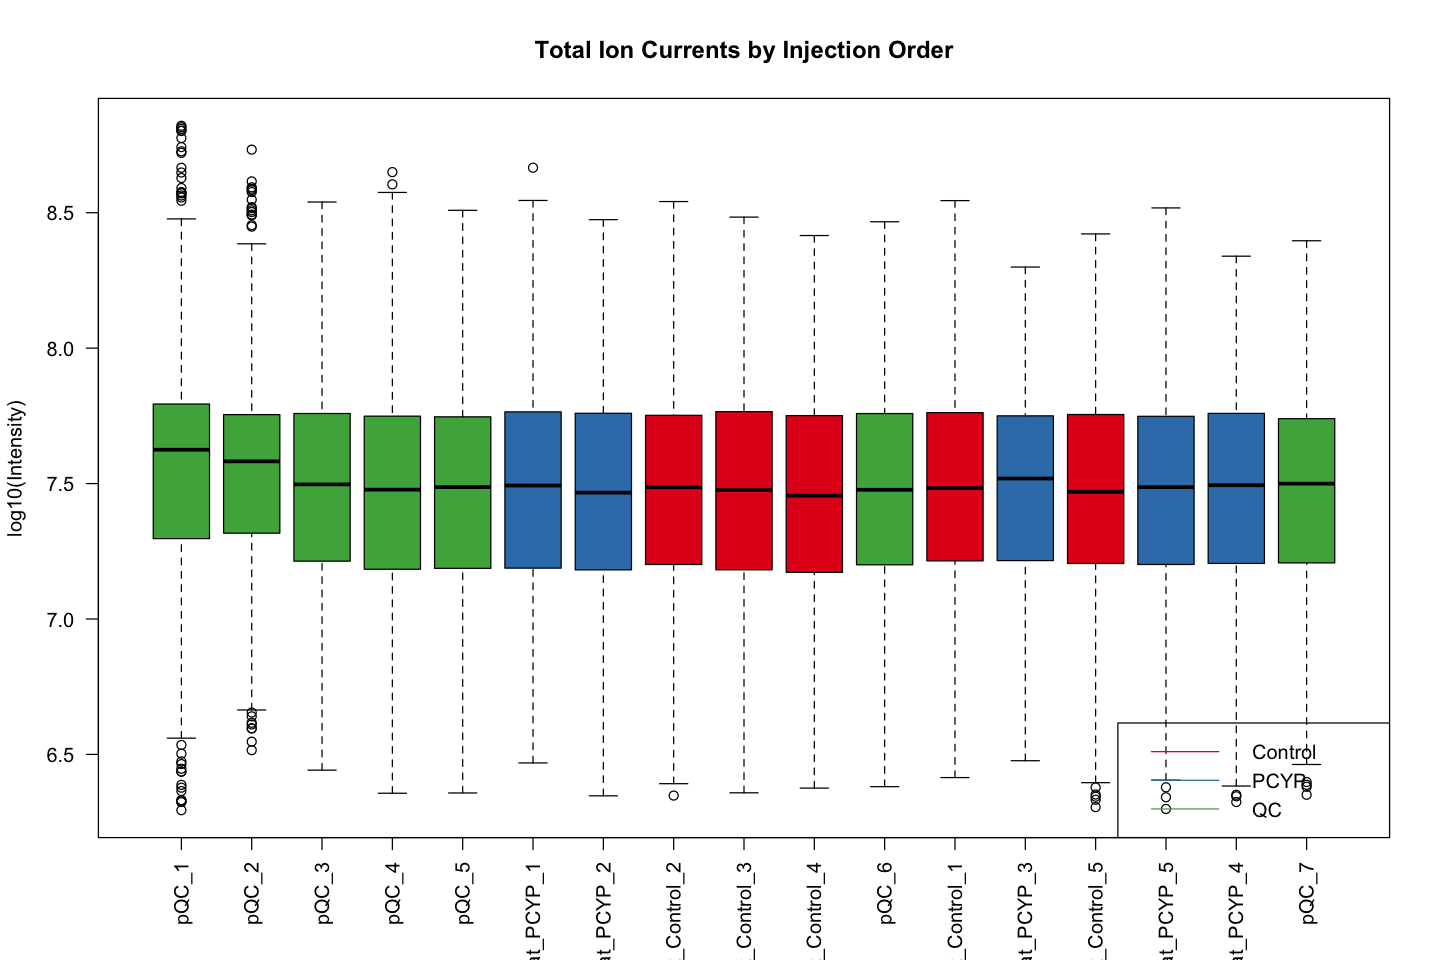

In [12]:
# Inspect boxplots of TICs by injection order
tics.summary <- split(tic(raw), f = fromFile(raw))

boxplot(sapply(tics.summary, log10), names = raw$sample_name, 
        col = group.colours[raw$sample_group], ylab = "log10(Intensity)", 
        main = "Total Ion Currents by Injection Order", las = 2)
legend("bottomright", legend = names(group.colours), 
       col = group.colours, lty = 1)

# Preprocessing of Raw Sample Files

# Peak Picking

Parameter used in this section were obtained using the one-by-one optimization performed by centWaveOpt. This approach was published at DOI: 10.1002/dta.2552 by Manier et al.

In [13]:
cwp <- CentWaveParam(peakwidth = c(8.9, 25), ppm = 2.5, snthresh = 15, 
                     mzdiff = 0.034,  prefilter = c(6, 100))

suppressMessages(
    
    set <- findChromPeaks(raw, param = cwp)
    
    )

In [14]:
## Define sample colours
sample.colours <- paste0(brewer.pal(3, "Set1")[1:3], "60")
names(sample.colours) <- c("Control", "PCYP", "QC")
sample.colours <- sample.colours[raw$sample_group]

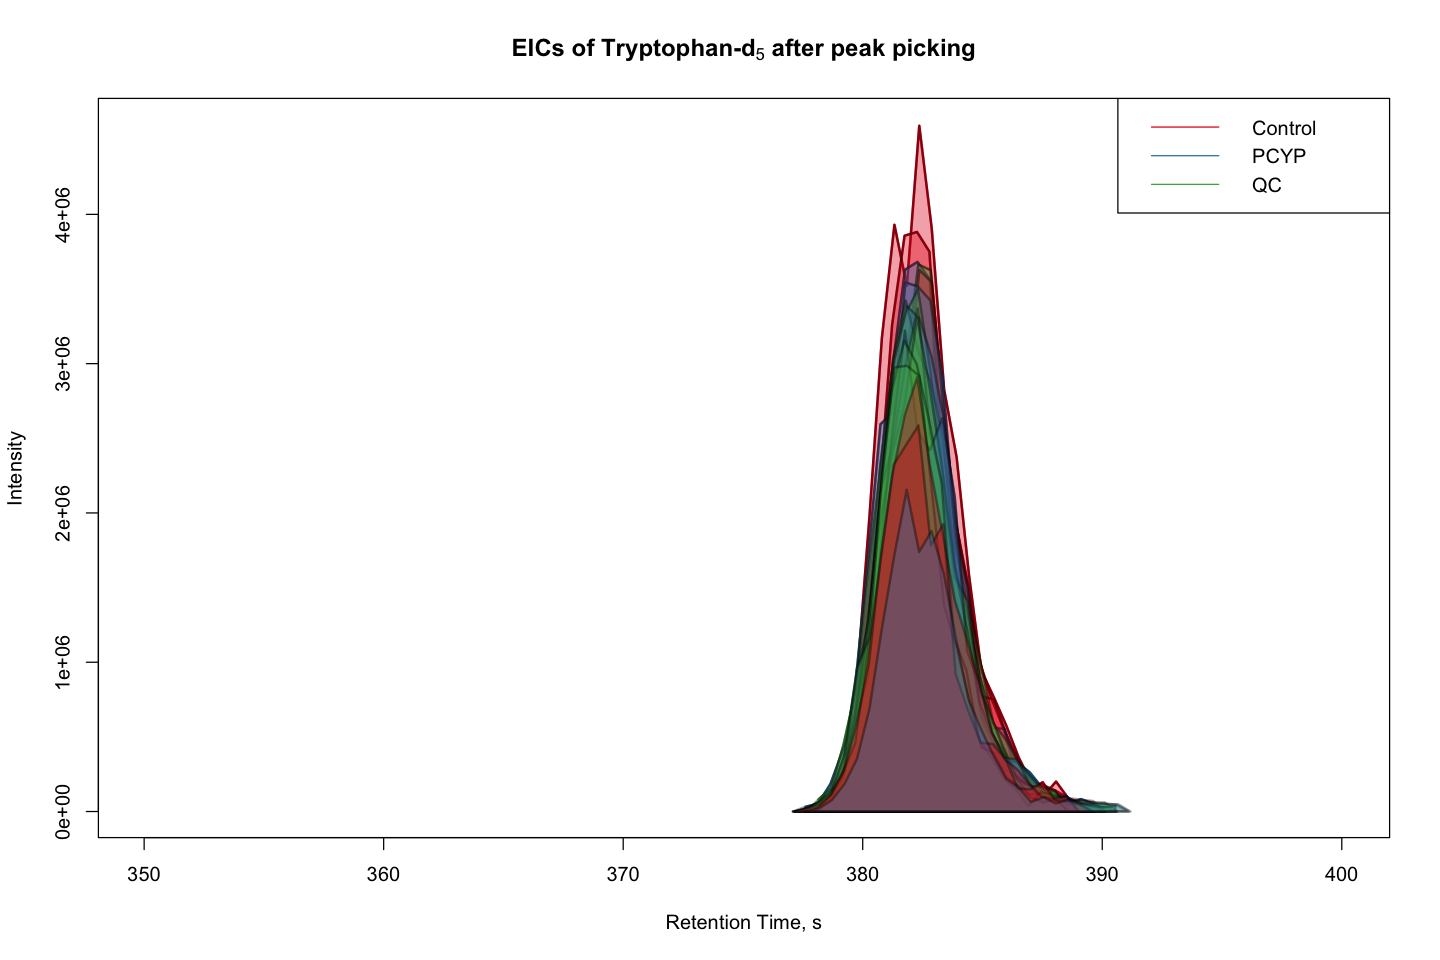

In [15]:
## Plot Tryptophan-d5 after peak picking (m/z 210.1291, 168 s)
trpd5.picked <- chromatogram(set, mz = c(208.1124, 208.1144), rt = c(350, 400)) 

plot(trpd5.picked, col = group.colours[trpd5.raw$sample_group], lwd = 2,
     peakBg = sample.colours[chromPeaks(trpd5.picked)[, "sample"]],
     main = bquote(bold("EICs of Tryptophan-d"[5]*" after peak picking")), xlab = "Retention Time, s",
     ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

# Retention Time Correction

In [16]:
suppressMessages({
    
    set <- adjustRtime(set, param = ObiwarpParam(binSize = 0.6))
    set <- dropAdjustedRtime(set)

    pdp <- PeakDensityParam(sampleGroups = set$sample_group, bw = 0.9)
    set <- groupChromPeaks(set, param = pdp)

    ## Define subset alignment options and perform the alignment
    pgp <- PeakGroupsParam(minFraction = 0.8, 
                           subset = which(set$sample_group == "QC"),
                           subsetAdjust = "average", span = 0.2)
    set <- adjustRtime(set, param = pgp)
    
})

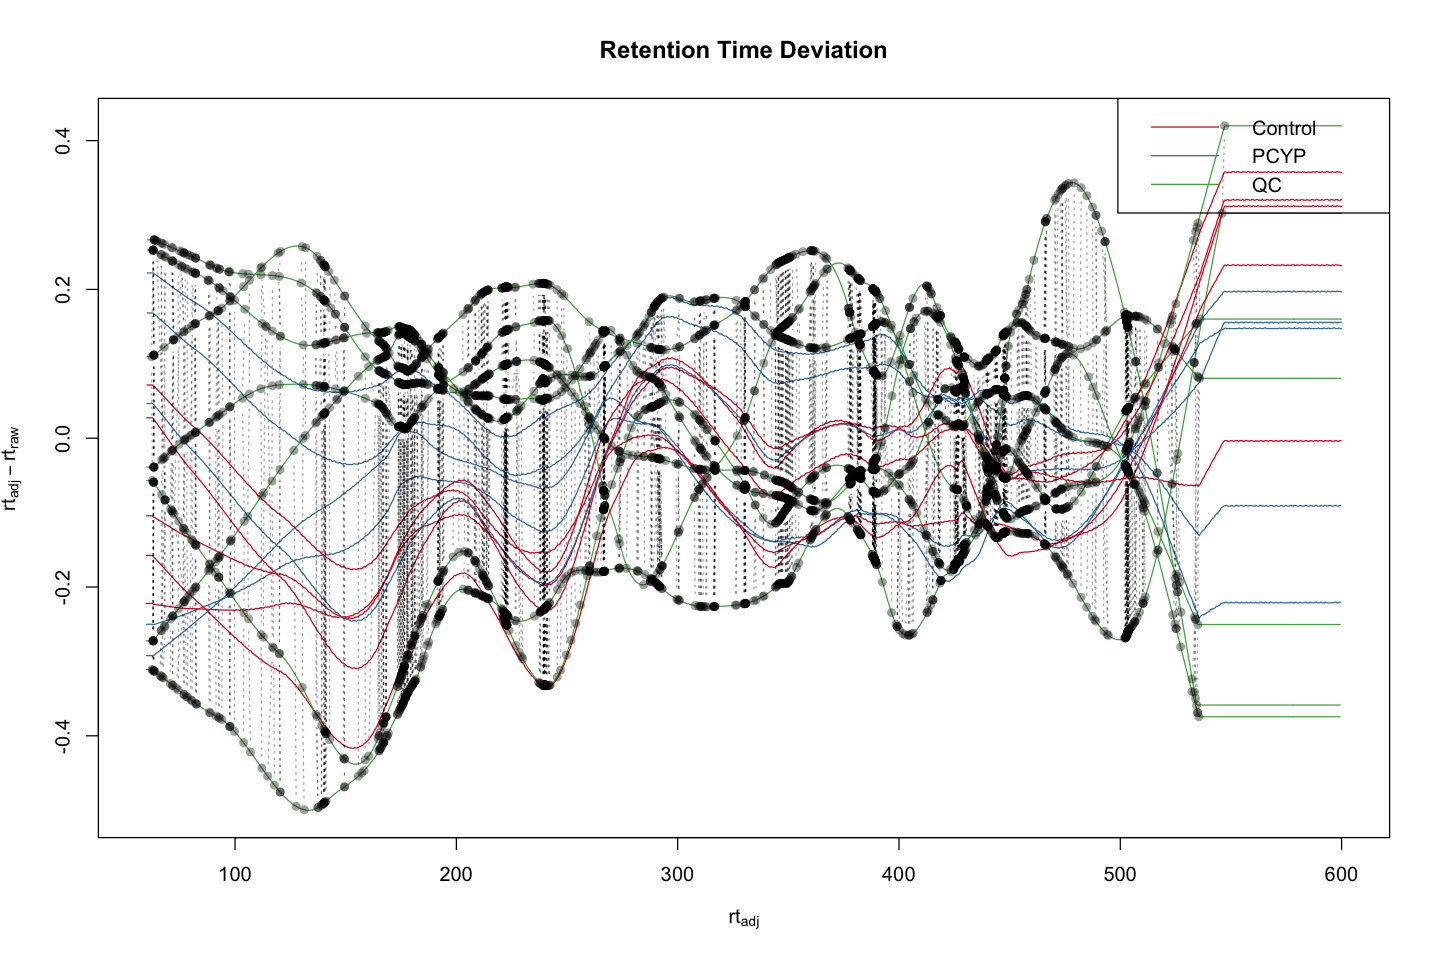

In [17]:
## Plot difference of adjusted to raw retention time.
plotAdjustedRtime(set, col = group.colours[set$sample_group], 
                  main = "Retention Time Deviation")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

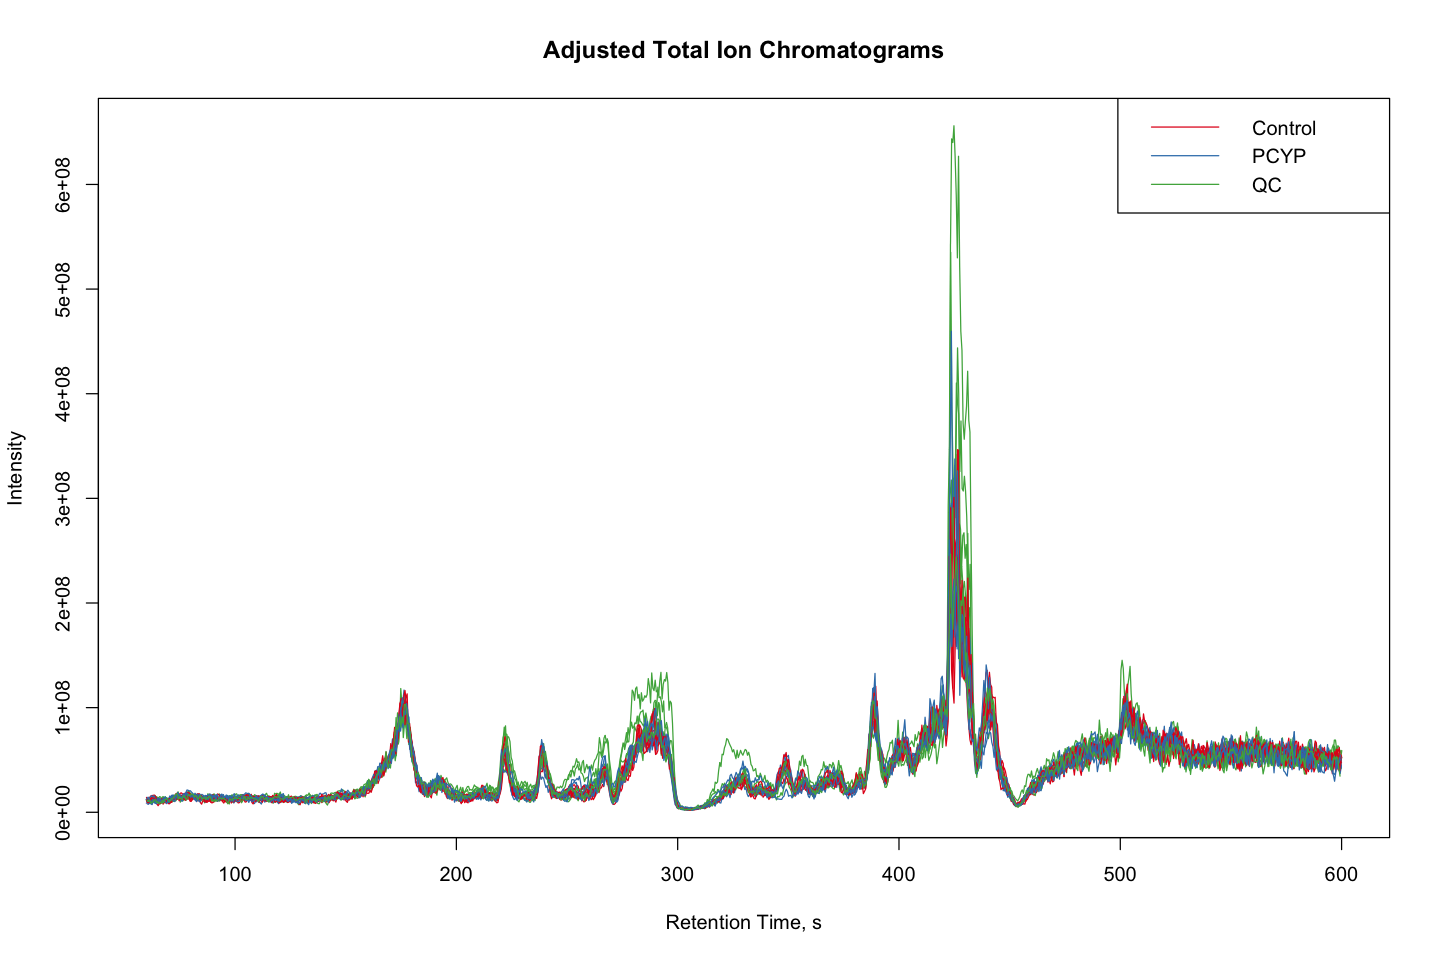

In [18]:
## Get the retention time-adjusted total ion chromatograms.
tics.corr <- chromatogram(set, aggregationFun = "sum")

plot(tics.corr, col = group.colours[tics.corr$sample_group], 
     peakType = "none", main = "Adjusted Total Ion Chromatograms", 
     xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), col = group.colours, lty = 1)

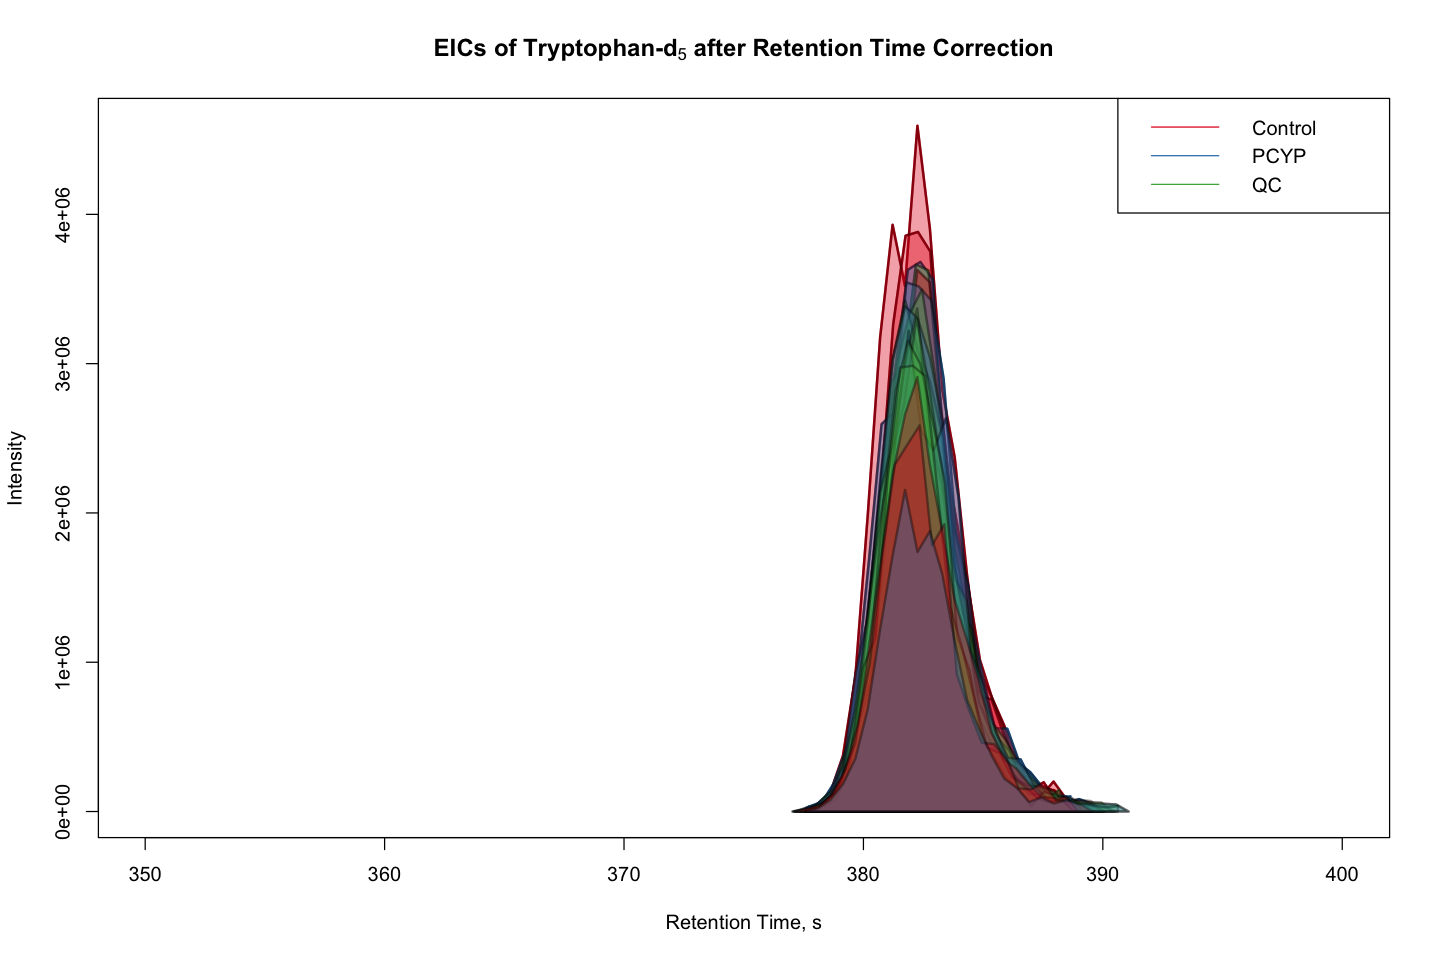

In [19]:
## Plot tryptophan-d5 after retention time correction (m/z 210.1291, 168 s)
trpd5.corr <- chromatogram(set, mz = c(208.1124, 208.1144), rt = c(350, 400))

plot(trpd5.corr, col = group.colours[trpd5.raw$sample_group], lwd = 2,
     peakBg = sample.colours[chromPeaks(trpd5.corr)[, "sample"]],
     peakPch = 16, main = bquote(bold("EICs of Tryptophan-d"[5]*" after Retention Time Correction")),
     xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

# Peak Grouping

In [20]:
suppressMessages(
    
    set <- groupChromPeaks(set, param = pdp)
    
)

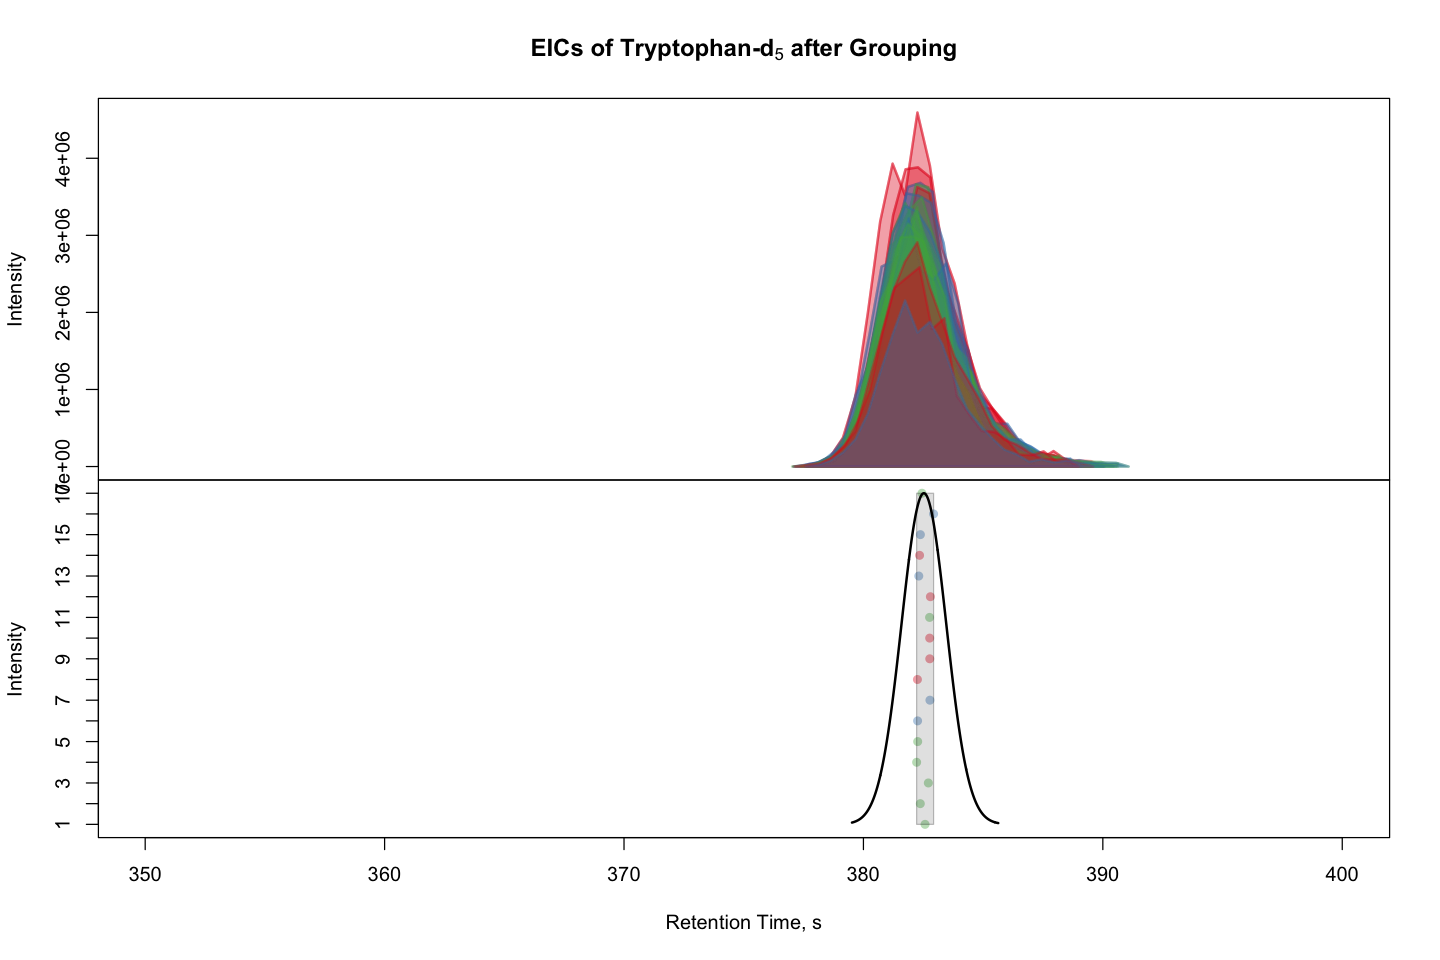

In [21]:
## Plot trp-d5 after peak grouping
trpd5.grouped <- chromatogram(set, mz = c(208.1124, 208.1144), rt = c(350, 400))

## Define the parameters for the peak density method
plotChromPeakDensity(trpd5.grouped, col = sample.colours, param = pdp, lwd = 2,
                     peakBg = sample.colours[chromPeaks(trpd5.grouped)[, "sample"]],
                     peakCol = sample.colours[chromPeaks(trpd5.grouped)[, "sample"]],
                     peakPch = 16, main = bquote(bold("EICs of Tryptophan-d"[5]*" after Grouping")),
                     xlab = "Retention Time, s", ylab = "Intensity")

# Peak Filling

In [22]:
suppressMessages(    
     
    set <- fillChromPeaks(set, param = ChromPeakAreaParam())
    
)

ERROR: Error in h(simpleError(msg, call)): Fehler bei der Auswertung des Argumentes 'param' bei der Methodenauswahl für Funktion 'fillChromPeaks': konnte Funktion "ChromPeakAreaParam" nicht finden


# Postprocessing


# Annotation of Adducts and Isotopes

In [23]:
## Summarise experiment
results <- quantify(set, value = "into")
class(results)

[1] "SummarizedExperiment"
attr(,"package")
[1] "SummarizedExperiment"

In [24]:
rowData(results) %>%
head()

DataFrame with 6 rows and 12 columns
           mzmed     mzmin     mzmax     rtmed     rtmin     rtmax    npeaks
       <numeric> <numeric> <numeric> <numeric> <numeric> <numeric> <numeric>
FT0001   73.4791   73.4655   73.5104   76.6023   75.0393   78.7494         6
FT0002   73.4967   73.4767   73.5228   62.0255   61.7480   62.5444         4
FT0003   89.0236   89.0235   89.0236  260.4651  259.8417  261.8880         5
FT0004   96.9593   96.9593   96.9594  502.6572  502.4089  503.2007        17
FT0005  103.0394  103.0393  103.0394  140.5123  139.8191  140.8240        17
FT0006  112.9851  112.9850  113.0239  447.5821  443.9787  448.6634        32
         Control      PCYP        QC            peakidx  ms_level
       <numeric> <numeric> <numeric>             <list> <integer>
FT0001         3         1         2 2821,3793,7688,...         1
FT0002         1         3         0 4763,5763,6686,...         1
FT0003         3         2         0 5146,7067,8002,...         1
FT0004         5 

In [25]:
## Add classic feature names
rowData(results)$label <- paste0("M",round(rowData(results)$mzmed,0),
                           "T", round(rowData(results)$rtmed,0))
rowData(results) %>%
head()

DataFrame with 6 rows and 13 columns
           mzmed     mzmin     mzmax     rtmed     rtmin     rtmax    npeaks
       <numeric> <numeric> <numeric> <numeric> <numeric> <numeric> <numeric>
FT0001   73.4791   73.4655   73.5104   76.6023   75.0393   78.7494         6
FT0002   73.4967   73.4767   73.5228   62.0255   61.7480   62.5444         4
FT0003   89.0236   89.0235   89.0236  260.4651  259.8417  261.8880         5
FT0004   96.9593   96.9593   96.9594  502.6572  502.4089  503.2007        17
FT0005  103.0394  103.0393  103.0394  140.5123  139.8191  140.8240        17
FT0006  112.9851  112.9850  113.0239  447.5821  443.9787  448.6634        32
         Control      PCYP        QC            peakidx  ms_level       label
       <numeric> <numeric> <numeric>             <list> <integer> <character>
FT0001         3         1         2 2821,3793,7688,...         1      M73T77
FT0002         1         3         0 4763,5763,6686,...         1      M73T62
FT0003         3         2         

In [26]:
assay(results) %>% 
head()

,pQC_1.mzXML,pQC_2.mzXML,pQC_3.mzXML,pQC_4.mzXML,pQC_5.mzXML,1h_Plasna_Rat_PCYP_1.mzXML,1h_Plasna_Rat_PCYP_2.mzXML,1h_Plasna_Rat_Control_2.mzXML,1h_Plasna_Rat_Control_3.mzXML,1h_Plasna_Rat_Control_4.mzXML,pQC_6.mzXML,1h_Plasna_Rat_Control_1.mzXML,1h_Plasna_Rat_PCYP_3.mzXML,1h_Plasna_Rat_Control_5.mzXML,1h_Plasna_Rat_PCYP_5.mzXML,1h_Plasna_Rat_PCYP_4.mzXML,pQC_7.mzXML
FT0001,NA,NA,NA,117907.0,95420.07,NA,NA,NA,168760.2,NA,NA,92422.11,NA,95459.49,NA,90246.72,NA
FT0002,NA,NA,NA,NA,NA,57129.45,86770.54,94539.22,NA,NA,NA,NA,65466.4,NA,NA,NA,NA
FT0003,NA,NA,NA,NA,NA,2738231.34,NA,7358789.27,4687861.3,4810066,NA,NA,NA,NA,4620140,NA,NA
FT0004,1077319.8,1856200.7,2359019.2,1556455.9,2878805.99,2577499.02,2382904.18,2036606.35,1977953.1,1401424,1577063.8,2338510.37,1578155.1,1822188.57,2277694,1847671.88,1823614
FT0005,513250.9,910492.2,957861.5,777371.8,1125655.61,939723.62,556535.26,1312069.12,1686096.1,1302040,929032.8,817982.12,336255.6,913594.92,2084778,1287505.95,1232226
FT0006,34866597.4,41322344.8,49117639.4,45872025.3,51211179.80,41775798.72,353130.72,58412490.93,32349112.2,55346317,44711597.8,65020012.85,37324668.0,40580880.07,57748366,36098532.02,53613872


In [27]:
## Perform annotation using CAMERA
suppressMessages({
    
    camera <- set %>%
              as("xcmsSet") %>%
              CAMERA::annotate(polarity  = "negative") %>%
              getPeaklist() %>%
              dplyr::select(isotopes, adduct, pcgroup)
    
})

## Save annotation results in SummarizedExperiment class
rowData(results)$isotopes <- camera$isotopes
rowData(results)$adduct <- camera$adduct
rowData(results)$pcgroup <- camera$pcgroup

Start grouping after retention time.
Created 123 pseudospectra.
Generating peak matrix!
Run isotope peak annotation
 % finished: 10  20  30  40  50  60  70  80  90  100  
Found isotopes: 205 
Start grouping after correlation.
Generating EIC's .. 

Calculating peak correlations in 123 Groups... 
 % finished: 10  20  30  40  50  60  70  80  90  100  

Calculating graph cross linking in 123 Groups... 
 % finished: 10  20  30  40  50  60  70  80  90  100  
New number of ps-groups:  549 
xsAnnotate has now 549 groups, instead of 123 
Generating peak matrix for peak annotation!

Calculating possible adducts in 549 Groups... 
 % finished: 10  20  30  40  50  60  70  80  90  100  


# Scaling

Before log10 transformation, every NA in the data matrix is replaced by the surrogate LOD according to Wehrens et al. at DOI: 10.1007/s11306-016-1015-8. The surrogate LOD is the lowest area that was measured during the analysis.

In [28]:
assays(results)

List of length 1
names(1): raw

In [29]:
# Replacing 0s with surrogate LOD
lod <- assay(results, "raw")[is.na(assay(results, "raw")) == FALSE] %>%
       min()
assay(results, "raw")[is.na(assay(results, "raw"))] <- lod

# Create assay results after log10 transformation
assay(results, "scaled") <- assay(results, "raw") %>%
                            log10()

In [30]:
assays(results)

List of length 2
names(2): raw scaled

In [31]:
results %>%
assay("scaled") %>%
head()

,pQC_1.mzXML,pQC_2.mzXML,pQC_3.mzXML,pQC_4.mzXML,pQC_5.mzXML,1h_Plasna_Rat_PCYP_1.mzXML,1h_Plasna_Rat_PCYP_2.mzXML,1h_Plasna_Rat_Control_2.mzXML,1h_Plasna_Rat_Control_3.mzXML,1h_Plasna_Rat_Control_4.mzXML,pQC_6.mzXML,1h_Plasna_Rat_Control_1.mzXML,1h_Plasna_Rat_PCYP_3.mzXML,1h_Plasna_Rat_Control_5.mzXML,1h_Plasna_Rat_PCYP_5.mzXML,1h_Plasna_Rat_PCYP_4.mzXML,pQC_7.mzXML
FT0001,4.231433,4.231433,4.231433,5.071539,4.979640,4.231433,4.231433,4.231433,5.227270,4.231433,4.231433,4.965776,4.231433,4.979819,4.231433,4.955431,4.231433
FT0002,4.231433,4.231433,4.231433,4.231433,4.231433,4.756860,4.938372,4.975612,4.231433,4.231433,4.231433,4.231433,4.816018,4.231433,4.231433,4.231433,4.231433
FT0003,4.231433,4.231433,4.231433,4.231433,4.231433,6.437470,4.231433,6.866806,6.670975,6.682151,4.231433,4.231433,4.231433,4.231433,6.664655,4.231433,4.231433
FT0004,6.032345,6.268625,6.372731,6.192137,6.459212,6.411199,6.377107,6.308907,6.296216,6.146570,6.197849,6.368939,6.198150,6.260593,6.357495,6.266625,6.260933
FT0005,5.710330,5.959276,5.981303,5.890629,6.051406,5.973000,5.745493,6.117957,6.226882,6.114624,5.968031,5.912744,5.526669,5.960754,6.319060,6.109749,6.090690
FT0006,7.542410,7.616185,7.691237,7.661548,7.709365,7.620925,5.547935,7.766506,7.509862,7.743089,7.650420,7.813047,7.571996,7.608321,7.761540,7.557490,7.729277


# Normalisation

In [32]:
## Define function to calculate ppm deviation
ppm <- function(x,y) {

    return(10^6 * (x - y) / y)

}

## Define function to identify row of compound
identify <- function(data, mz, rt, ppmlim, rtlim) {

    delta.mz <- abs(mapply(ppm, x = data$mzmed, y = mz))
    delta.rt <- abs(data$rtmed - rt)
    return(which(delta.mz < ppmlim & delta.rt < rtlim))
    
}

In [33]:
## Identify rownumber of internal standard tryptophan-d5
trpd5 <- results %>%
         rowData() %>%
         as.data.frame() %>%
         identify(mz = 208.1134, rt = 383, 5, 10)

In [34]:
## Normalise data to internal standard
norm.is <- function(x, is){x/x[is]}
assay(results, "norm") <- apply(assay(results, "scaled"),2, norm.is, is = trpd5)

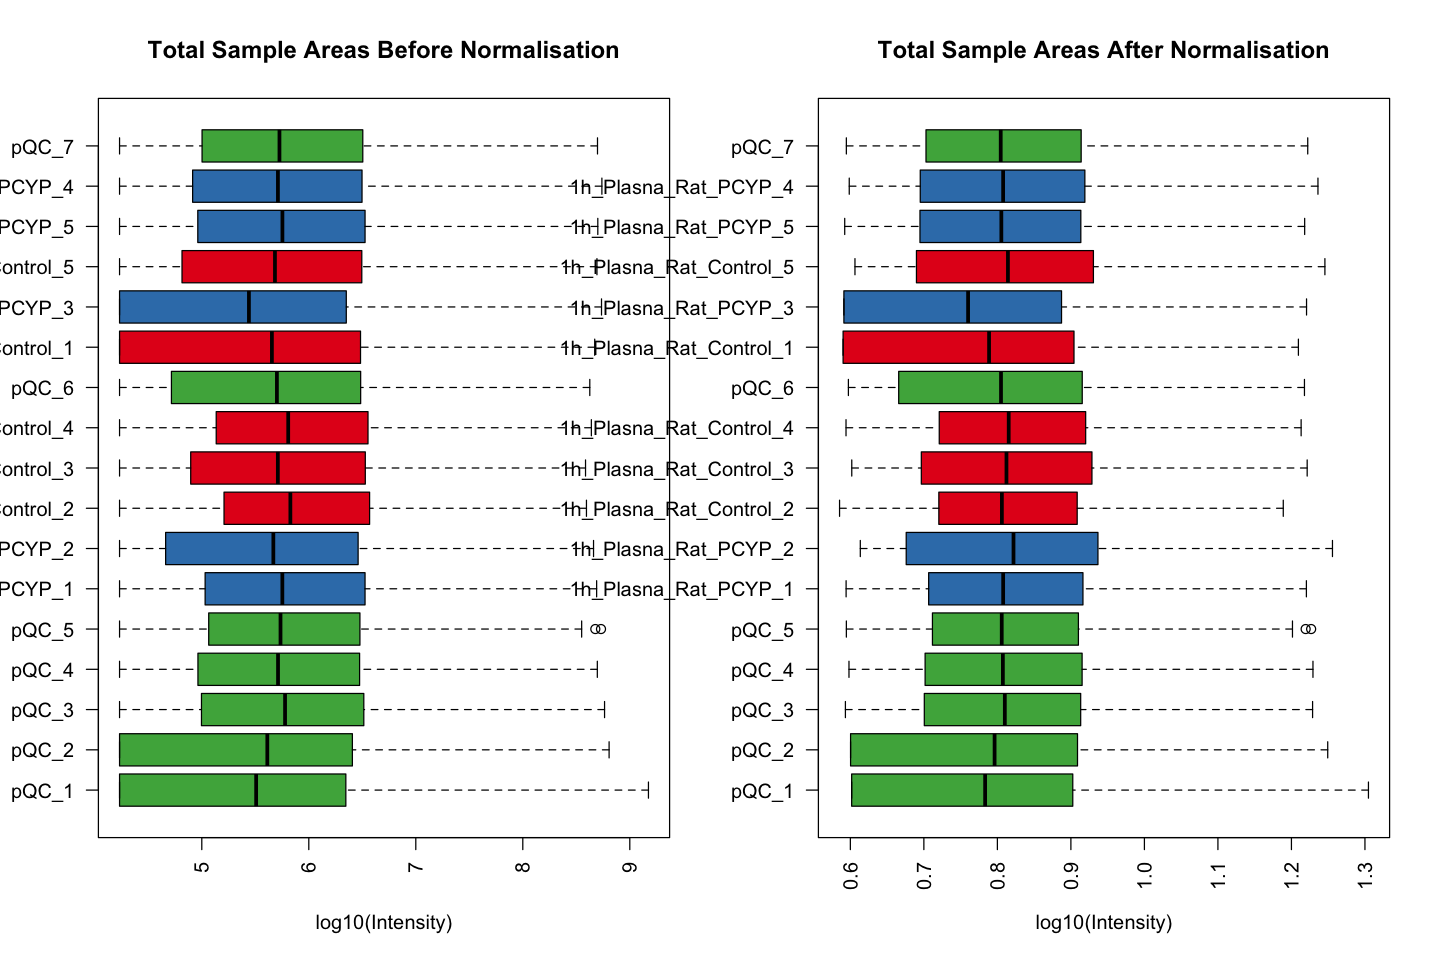

In [35]:
## Compare normalised and unnormalised data
par(mfrow = c(1,2))

results %>%
assay("scaled") %>%
boxplot(names = results$sample_name, horizontal = TRUE,
        col = group.colours[results$sample_group], xlab = "log10(Intensity)", 
        main = "Total Sample Areas Before Normalisation", las = 2)

results %>%
assay("norm") %>%
boxplot(names = results$sample_name, horizontal = TRUE,
        col = group.colours[results$sample_group], xlab = "log10(Intensity)", 
        main = "Total Sample Areas After Normalisation", las = 2)

# Batch correction

In [36]:
## Define function to perform batch correction
batchCorrection <-function(area, order, group, output = c("df", "corr")) {
        
    df <- data.frame(order = order, area = area)
    model <- lm(area ~ order, data = df[group == "QC",])
    df$pred <- predict(model, newdata = df)
    df$corr <- df$corr <- df$area - df$pred + mean (df$area)
    return(switch(output, df = df, corr = df$corr))
    
}

In [37]:
## Filter features by detectability in QC samples
#results.filtered <- results[rowData(results)$QC == 9,]

In [38]:
## Perform batch correction
assay(results, "batchcorr",
      withDimnames = FALSE) <- apply(assay(results, "scaled"), 
                                     1, batchCorrection, 
                                     order = set$sample_order, 
                                     group = set$sample_group, 
                                     output = "corr") %>%
                                     t()

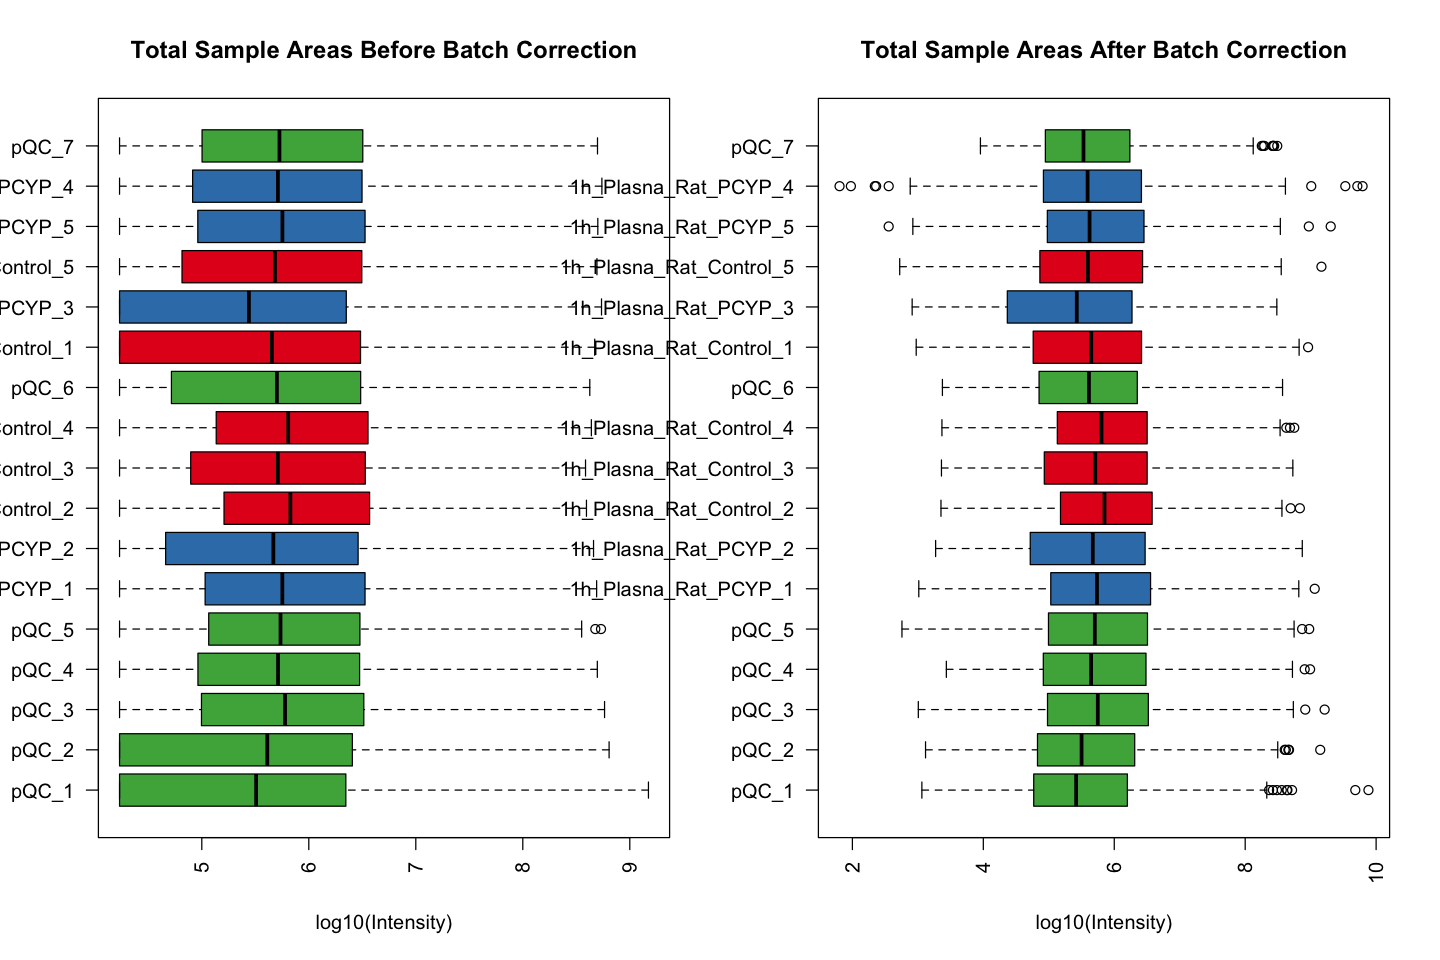

In [39]:
## Compare batch-corrected and uncorrected total sample areas
par(mfrow = c(1,2))

results %>%
assay("scaled") %>%
boxplot(names = results$sample_name, horizontal = TRUE,
        col = group.colours[results$sample_group], xlab = "log10(Intensity)", 
        main = "Total Sample Areas Before Batch Correction", las = 2)

results %>%
assay("batchcorr") %>%
boxplot(names = results$sample_name, horizontal = TRUE,
        col = group.colours[results$sample_group], xlab = "log10(Intensity)", 
        main = "Total Sample Areas After Batch Correction", las = 2)

In [40]:
## Compare batch-corrected and uncorrected areas of compounds
df <- batchCorrection(assay(results, "scaled")[51,], 
                      set$sample_order, set$sample_group, "df")

## Perform regression using corrected values
lm <- lm(area ~ order, data = df[results$sample_group == "QC",])
lm.new <- lm(corr ~ order, data = df[results$sample_group == "QC",])

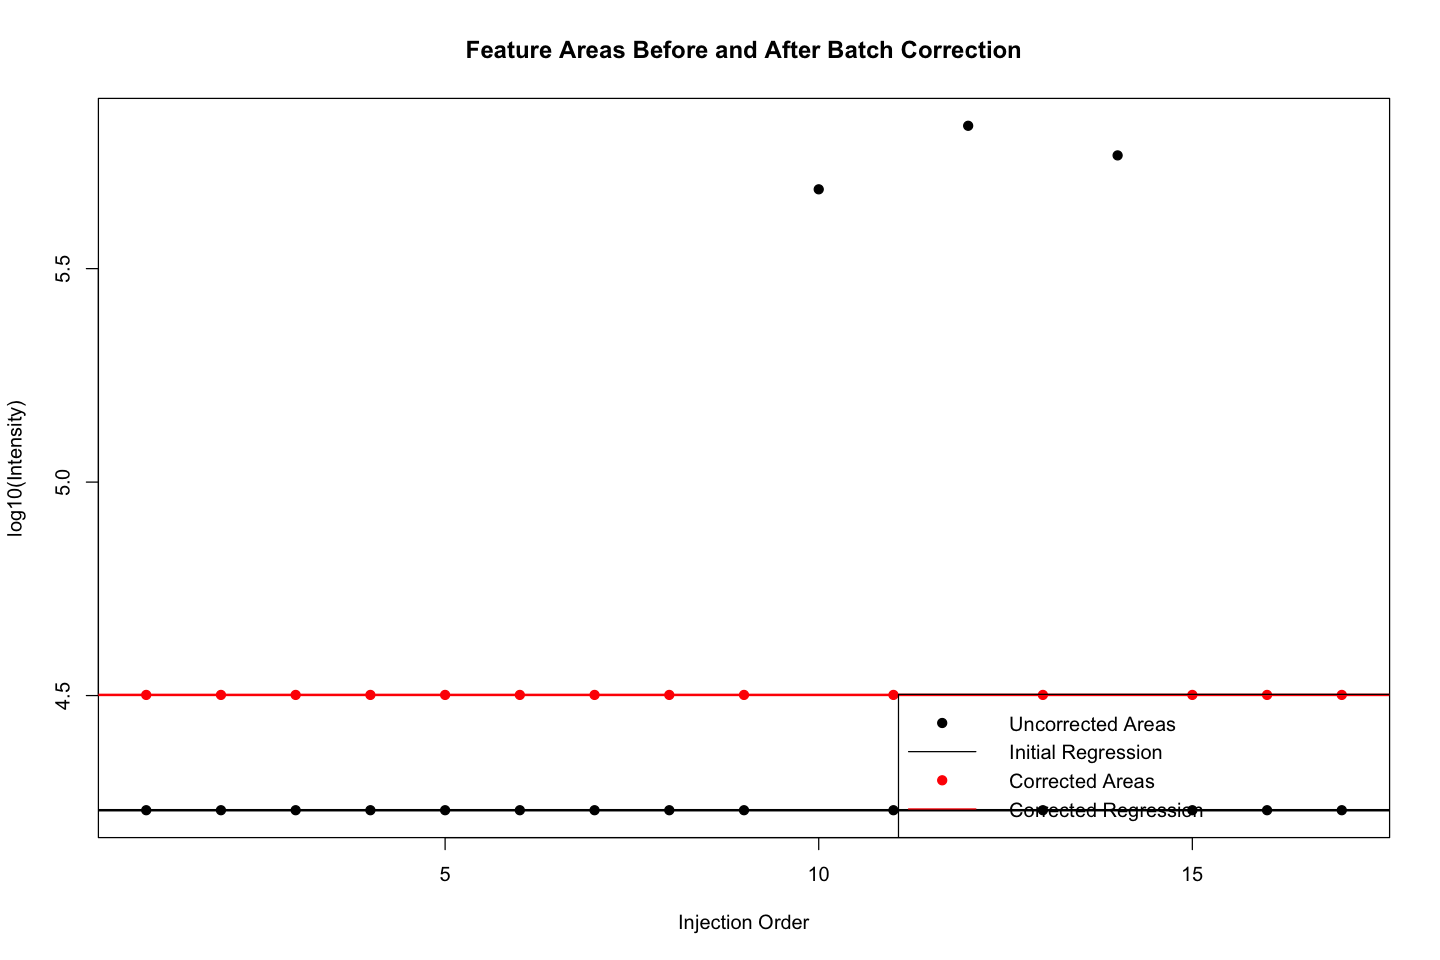

In [42]:
## Plot uncorrected and corrected models and data points
plot(df$order, df$area, col = "black", pch = 19,
     xlab = "Injection Order", ylab = "log10(Intensity)", 
     main = "Feature Areas Before and After Batch Correction")
abline(lm, lwd = 2, col = "black")
points(df$order, df$corr, col = "red", pch = 19)
abline(lm.new, lwd = 2, col = "red")
legend("bottomright", lty = c(NA,1,NA,1), pch=c(19,NA,19,NA),
       legend = c("Uncorrected Areas", "Initial Regression", 
                  "Corrected Areas", "Corrected Regression"), 
       col = c("black", "black", "red", "red"))